%load_ext autoreload
%autoreload 2

In [ ]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests

from decode_fish.funcs.merfish_eval import *
from starfish import data
import pprint

import io, requests
from sklearn.neighbors import NearestNeighbors

In [ ]:
bench = pd.read_csv(
    io.BytesIO(requests.get('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv').content),
    dtype={'barcode': object})

#See Fig. S4 https://www.pnas.org/content/113/39/11046

bench_df = bench.copy()
bench_df = bench_df[bench_df['total_magnitude']>10**0.75 * 4]
bench_df = bench_df[bench_df['area']>3]
bench_df['int'] = bench_df['total_magnitude']
bench_df['code_err'] = -bench_df['total_magnitude']

print(len(bench_df))

experiment = data.MERFISH(use_test_data=True)
code_ref = experiment.codebook.data.reshape([140,-1], order='F')
targets = experiment.codebook.indexes['target']

13832


In [ ]:
pred_df = pd.read_csv('../data/results/MERFISH/exp_c3d2x_01noise.csv')
pred_df = pd.read_csv('../data/results/MERFISH/exp_c3d_02noise.csv')
pred_df = exclude_borders(pred_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
pred_df.loc[pred_df['frame_idx']>7] = shift_df(pred_df[pred_df['frame_idx']>7], [5,20,0])
pred_df.loc[:,'comb_sig'] = np.sqrt(pred_df['x_sig']**2 + pred_df['y_sig']**2)
len(pred_df)

303099

100%|██████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 253.23it/s]


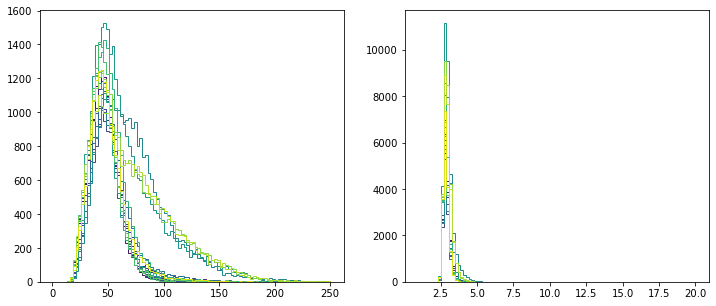

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,5))
plt.subplot(121)
cmap = sns.color_palette("viridis", n_colors=16)

for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    df1 = pred_df[pred_df['frame_idx']==i].copy()
    plt.hist(df1['comb_sig'], histtype='step', bins=np.linspace(1,250,101),color=cmap[i])
plt.subplot(122)
for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    df1 = pred_df[pred_df['frame_idx']==i].copy()
    plt.hist(df1['int'], histtype='step', color=cmap[i], bins=np.linspace(1,20,101))


In [ ]:
# pred_df0 = pd.read_csv('../data/results/MERFISH/exp_3_ch0.csv')
# pred_df1 = pd.read_csv('../data/results/MERFISH/exp_3_ch1.csv')
# pred_df1['frame_idx'] += 8
# pred_df1['loc_idx'] += pred_df0['loc_idx'].values[-1] + 1
# pred_df = pred_df0.append(pred_df1)
# pred_df = pred_df.reset_index(drop=True)
# pred_df = exclude_borders(pred_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
# pred_df.loc[pred_df['frame_idx']>7] = shift_df(pred_df[pred_df['frame_idx']>7], [5,20,0])
# len(pred_df)

In [ ]:
def norm_features(code, norm_order = 2):
    
    norm = np.linalg.norm(code, ord=norm_order, axis=1)
    code = code / norm[:, None]

    return code

def approximate_nearest_code(ref_code, pred_code, targets):
    
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='euclidean').fit(ref_code)
    metric_output, indices = nn.kneighbors(pred_code)
    gene_ids = np.ravel(targets.values[indices])

    return np.ravel(metric_output), gene_ids, indices

def make_roc(dfs, var='code_err', ascending=True):
    max_len = max([len(df) for df in dfs])
    x = np.arange(1000,max_len,100)
    y = []
    
    for df in dfs:

        df = df.sort_values(var, ascending=ascending)
        n_blanks = []
        for i in x:
            n_blanks.append((df[:int(i)]['gene'].str.contains('Blank')).sum())
        y.append(n_blanks)
        
    return x, y

In [ ]:
# Define points where to query. Something to replace pixels. Could do a fine grid. 

In [ ]:
def vcorrcoef(X,y):
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

In [ ]:
# norm_code = norm_features(code_ref) 
# group_rad = 150

# loc_df=pred_df.copy()

# N_imgs = loc_df['frame_idx'].max() + 1

# loc_df = loc_df.sort_values('comb_sig').reset_index(drop=True)

# xy = loc_df.loc[:,['x','y']].values
# xy_sig = loc_df.loc[:,['x_sig','y_sig']].values # * 0 + 25
# fr_idx = loc_df.loc[:,'frame_idx'].values
# grouped_bool = np.zeros(len(loc_df))

# tree = cKDTree(xy)
# code_errs = []

# seed_inds = []
# code_err = []
# code_ind = []

# for i in tqdm(range(5)):    
#     if not grouped_bool[i]:

#         ball_inds = np.array(tree.query_ball_point(xy[i], group_rad))
#         ball_inds = ball_inds[grouped_bool[ball_inds] == 0]

#         if len(ball_inds) >= 4:

#             frame_probs = np.zeros(N_imgs)
#             # Evaluate probs at the position of the seed localization
#             cdf = torch.distributions.normal.Normal(T([0,0]), (torch.sqrt(T(xy_sig[ball_inds][None])**2 + T(xy_sig[ball_inds][:,None])**2))).cdf(-abs(T(xy[ball_inds][None]) - T(xy[ball_inds][:,None]))).prod(-1)
#             cdf = cdf*(1-torch.diag(torch.ones(len(cdf))))
#             probs = (cdf*4).sum(0)/(len(cdf) - 1)
#             # If multiple localizations belong the same frame, chose the one with higehst prob.
#             sort_inds = np.argsort(-probs)
#             sort_fr_idx = fr_idx[ball_inds][sort_inds]
#             unique_inds = sort_inds[np.unique(sort_fr_idx, return_index=True)[1]] 

#             if len(unique_inds) >= 4:

#                 ball_inds = ball_inds[unique_inds]
#                 frame_probs[fr_idx[ball_inds]] = probs[unique_inds]

#                 frame_probs2 = frame_probs
                
#                 frame_probs = frame_probs**(1/10)
#                 code_errors = vcorrcoef(code_ref, frame_probs)
                
#                 frame_probs2 = frame_probs2**(1/1)
#                 code_errors2 = vcorrcoef(code_ref, frame_probs2)
                
#                 print('1',np.round(sorted(code_errors, reverse=True)[:10], 4))
#                 print('2',np.round(sorted(code_errors2, reverse=True)[:10], 4))
                
#                 print('1',np.argsort(-code_errors)[:10])
#                 print('1',np.argsort(-code_errors2)[:10])

#                 min_ind = np.argmax(code_errors)

#                 selected = ball_inds[np.intersect1d(fr_idx[ball_inds], code_ref[min_ind].nonzero()[0], assume_unique=True, return_indices=True)[1]]

#                 grouped_bool[selected] = 1

#                 seed_inds.append(i)
#                 code_err.append(code_errors[min_ind])
#                 code_ind.append(min_ind)

# loc_df = loc_df.loc[seed_inds]
# loc_df['code_err'] = code_err
# loc_df['code_inds'] = code_ind
# loc_df['gene'] = targets[code_ind]

In [ ]:
import torch.tensor as T

def get_codes(pred_df, group_rad=150, prob_smoothing=1):
    norm_code = norm_features(code_ref) 

    loc_df=pred_df.copy()

    N_imgs = loc_df['frame_idx'].max() + 1

    loc_df = loc_df.sort_values('comb_sig').reset_index(drop=True)

    xy = loc_df.loc[:,['x','y']].values
    xy_sig = loc_df.loc[:,['x_sig','y_sig']].values * prob_smoothing
    fr_idx = loc_df.loc[:,'frame_idx'].values
    grouped_bool = np.zeros(len(loc_df))

    tree = cKDTree(xy)
    code_errs = []

    seed_inds = []
    code_err = []
    code_ind = []

    for i in tqdm(range(len(loc_df))):
#     for i in tqdm(range(15000)):    
        if not grouped_bool[i]:

            ball_inds = np.array(tree.query_ball_point(xy[i], group_rad))
            ball_inds = ball_inds[grouped_bool[ball_inds] == 0]

            if len(ball_inds) >= 4:

                frame_probs = np.zeros(N_imgs)
                
                # Evaluate probs at the position of the seed localization
#                 probs = torch.exp(torch.distributions.normal.Normal(T(xy[ball_inds]), T(xy_sig[ball_inds])).log_prob(T(xy[i])).sum(-1))
                
                cdf = torch.distributions.normal.Normal(T([0,0]), (torch.sqrt(T(xy_sig[ball_inds][None])**2 + T(xy_sig[ball_inds][:,None])**2))).cdf(-abs(T(xy[ball_inds][None]) - T(xy[ball_inds][:,None]))).prod(-1)
                cdf = cdf*(1-torch.diag(torch.ones(len(cdf))))
                probs = (cdf*4).sum(0)/(len(cdf) - 1)                
                
                # If multiple localizations belong the same frame, chose the one with higehst prob.
                sort_inds = np.argsort(-probs)
                sort_fr_idx = fr_idx[ball_inds][sort_inds]
                unique_inds = sort_inds[np.unique(sort_fr_idx, return_index=True)[1]] 
                
                if len(unique_inds) >= 4:
                    
                    ball_inds = ball_inds[unique_inds]
                    frame_probs[fr_idx[ball_inds]] = probs[unique_inds]
                    
#                     frame_probs = np.clip(frame_probs,0.,np.sort(frame_probs[frame_probs.nonzero()])[1])
#                     frame_probs = frame_probs**(1/prob_smoothing)
#                     code_errors = np.sqrt(((norm_code - norm_features(frame_probs[None]))**2).sum(-1))

#                     frame_probs = frame_probs/frame_probs.max()
#                     code_errors = np.sqrt(((code_ref - (frame_probs[None]))**2).sum(-1))
            
#                     frame_probs = frame_probs**(1/prob_smoothing)
                    code_errors = 1-vcorrcoef(code_ref, frame_probs)

                    min_ind = np.argmin(code_errors)

                    selected = ball_inds[np.intersect1d(fr_idx[ball_inds], code_ref[min_ind].nonzero()[0], assume_unique=True, return_indices=True)[1]]

                    grouped_bool[selected] = 1

                    seed_inds.append(i)
                    code_err.append(code_errors[min_ind])
                    code_ind.append(min_ind)

    loc_df = loc_df.loc[seed_inds]
    loc_df['code_err'] = code_err
    loc_df['code_inds'] = code_ind
    loc_df['gene'] = targets[code_ind]

    return loc_df

In [ ]:
res_df1 = get_codes(pred_df, group_rad=150, prob_smoothing=1)
# res_df4 = get_codes(pred_df, group_rad=150, prob_smoothing=50)

100%|█████████████████████████████████████████████████████| 303099/303099 [01:06<00:00, 4536.17it/s]


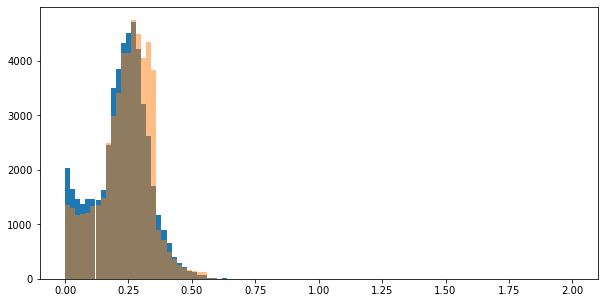

In [ ]:
plt.figure(figsize=(10,5))
_ = plt.hist(res_df1['code_err'], bins=np.linspace(0,2,101))
_ = plt.hist(res_df2['code_err'], bins=np.linspace(0,2,101), alpha=0.5)

In [ ]:
x, ys = make_roc([res_df1, res_df4, bench_df])
names = ['cdf1','cdf3','cf20','cdf50','cdf100','bench']

(0.0, 20000.0)

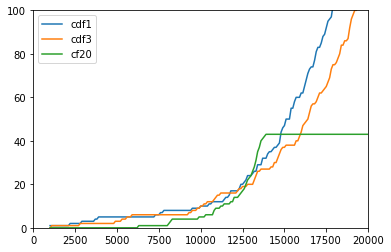

In [ ]:
for i in range(len(ys)):
    
    plt.plot(x, ys[i], label=names[i])
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 20000)

In [ ]:
bench_match = bench_df.copy()
bench_match.loc[:,'frame_idx'] = 0
bench_match.loc[:,'loc_idx'] = np.arange(len(bench_match))
bench_match.loc[:,'int'] = bench_match['total_magnitude']
bench_match.loc[:,'z'] = 50/100
bench_match = px_to_nm(bench_match)

res_df1[:15000].loc[:,'frame_idx'] = 0

_,_,shift = matching(bench_match, res_df1[:15000], tolerance=250, print_res=False)

bench_match = shift_df(bench_match, shift=-np.array(shift))

_,_,shift = matching(bench_match, res_df1[:15000], tolerance=250, print_res=False)

bench_match = shift_df(bench_match, shift=-np.array(shift))
_,matches,shift = matching(bench_match, res_df1[:15000], tolerance=250, print_res=True)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Recall: 0.523
Precision: 0.483
Jaccard: 33.525
RMSE_vol: 105.438
Eff_3d: 15.157
FN: 6593.0 FP: 7761.0
Num. matches: 7239.000
Shift: 3.32,3.19,0.13


In [ ]:
bench_match = bench_df.copy()
bench_match.loc[:,'frame_idx'] = 0
bench_match.loc[:,'loc_idx'] = np.arange(len(bench_match))
bench_match.loc[:,'int'] = bench_match['total_magnitude']
bench_match.loc[:,'z'] = 50/100
bench_match = px_to_nm(bench_match)

res_df1[:15000].loc[:,'frame_idx'] = 0

_,_,shift = matching(bench_match, res_df1[:15000], tolerance=250, print_res=False)

bench_match = shift_df(bench_match, shift=-np.array(shift))

_,_,shift = matching(bench_match, res_df1[:15000], tolerance=250, print_res=False)

bench_match = shift_df(bench_match, shift=-np.array(shift))
_,matches,shift = matching(bench_match, res_df1[:15000], tolerance=250, print_res=True)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Recall: 0.496
Precision: 0.457
Jaccard: 31.216
RMSE_vol: 106.848
Eff_3d: 12.906
FN: 6973.0 FP: 8141.0
Num. matches: 6859.000
Shift: 4.24,3.28,0.01
